<a href="https://colab.research.google.com/github/AnoushaPawarCTRL/icebergsFYP/blob/main/Arctic2_0_U_net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow opencv-python rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import os
import numpy as np
import rasterio
import cv2
from sklearn.model_selection import train_test_split, LeaveOneOut

# Paths to your image and mask folders
image_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked"
mask_folder = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_masked"

# Load TIFF images and masks
def load_data(image_folder, mask_folder):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_name, mask_name in zip(image_files, mask_files):
        print(f"Image: {img_name}, Mask: {mask_name}")
        img_path = os.path.join(image_folder, img_name)
        mask_path = os.path.join(mask_folder, mask_name)

        with rasterio.open(img_path) as img_file:
            img = img_file.read(1)
            img = cv2.resize(img, (256, 256))  # Resize for consistency
            images.append(img)

        with rasterio.open(mask_path) as mask_file:
            mask = mask_file.read(1)
            mask = cv2.resize(mask, (256, 256))  # Resize to match image
            masks.append(mask)

    images = np.expand_dims(np.array(images), axis=-1) / 255.0  # Normalize
    masks = np.expand_dims(np.array(masks), axis=-1) / 255.0  # Normalize
    return np.array(images), np.array(masks)

images, masks = load_data(image_folder, mask_folder)


Image: A23A_001_reprojected.tif, Mask: A23A_001_mask.tif
Image: A74A_001_reprojected.tif, Mask: A74A_001_mask.tif
Image: A76C_001_reprojected.tif, Mask: A76C_001_mask.tif
Image: A80A_001_reprojected.tif, Mask: A80A_001_mask.tif
Image: A81_001_reprojected.tif, Mask: A81_001_mask.tif
Image: A83_001_reprojected.tif, Mask: A83_001_mask.tif
Image: B09B_001_reprojected.tif, Mask: B09B_001_mask.tif
Image: B22A_001_reprojected.tif, Mask: B22A_001_mask.tif
Image: C15_001_reprojected.tif, Mask: C15_001_mask.tif
Image: D33A_001_reprojected.tif, Mask: D33A_001_mask.tif


In [ ]:
# U-Net Model
def unet(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D((2, 2))(conv4)
    merge5 = Concatenate()([conv3, up5])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    merge6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    merge7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs, outputs)
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.metrics import f1_score

def calculate_f1_score(y_true, y_pred):
    #threshold predicted mask
    y_pred = (y_pred > 0.2).astype(int)
    y_true = y_true.astype(int)

    #flatten array to calculate F1 score
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    return f1_score(y_true, y_pred)

loo = LeaveOneOut()
f1_scores = []

#Perform LOO-CV
for train_idx, val_idx in loo.split(images):
    X_train, X_val = np.array(images)[train_idx], np.array(images)[val_idx]
    y_train, y_val = np.array(masks)[train_idx], np.array(masks)[val_idx]

    #train
    model.fit(X_train, y_train, epochs=10, batch_size=8)

    #validation set
    predictions = model.predict(X_val)

    #Calculate F1 score
    score = calculate_f1_score(y_val, predictions)
    f1_scores.append(score)


print(f"Average F1 Score: {np.mean(f1_scores)}")


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9798 - loss: 0.3320
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9933 - loss: 1.1452
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9932 - loss: 0.0900
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9932 - loss: 0.0718
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9932 - loss: 0.0317
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9932 - loss: 0.0099
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9933 - loss: 0.0022
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9937 - loss: 9.0904e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9932 - loss: 6.5374e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9932 - loss: 5.2366e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9930 - loss: 6.9644e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9928 - loss: 8.4628e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9928 - loss: 0.0011
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9932 - loss: 8.5275e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9932 - loss: 7.0029e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9928 - loss: 7.0827e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9927 - loss: 6.7086e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9927 - loss: 6.3151e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9928 - loss: 5.8161e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9933 - loss: 5.1132e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9929 - loss: 4.7745e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9927 - loss: 4.7852e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9927 - loss: 4.4964e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9927 - loss: 4.4715e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9931 - loss: 4.5172e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9933 - loss: 4.5476e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9927 - loss: 4.3426e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9927 - loss: 6.0547e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9929 - loss: 4.4387e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9928 - loss: 7.4665e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9924 - loss: 7.4432e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9926 - loss: 5.0164e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9926 - loss: 3.9223e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9925 - loss: 5.3540e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9924 - loss: 4.7865e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9927 - loss: 4.1532e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9927 - loss: 5.8165e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.9925 - loss: 5.5380e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9927 - loss: 4.3925e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.9929 - loss: 3.6270e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9939 - loss: 3.3409e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9938 - loss: 3.7964e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9938 - loss: 3.4137e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9939 - loss: 3.0536e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9937 - loss: 3.0881e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9943 - loss: 2.7375e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9938 - loss: 2.8899e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9939 - loss: 2.8244e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9937 - loss: 2.7735e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.9943 - loss: 2.4521e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9927 - loss: 2.9986e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9926 - loss: 2.9568e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step - accuracy: 0.9926 - loss: 2.8610e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9927 - loss: 2.7742e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.9925 - loss: 2.7572e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.9926 - loss: 2.6064e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9927 - loss: 2.5854e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9928 - loss: 2.4388e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9927 - loss: 2.4032e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9925 - loss: 2.3981e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9930 - loss: 2.5782e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9931 - loss: 2.8733e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9935 - loss: 2.1107e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9931 - loss: 2.2504e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9930 - loss: 2.3547e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9930 - loss: 2.2245e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9930 - loss: 2.4009e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9931 - loss: 2.4552e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.9930 - loss: 2.7512e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.9932 - loss: 2.0785e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9945 - loss: 2.8689e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9943 - loss: 2.2026e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9941 - loss: 2.2323e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9941 - loss: 1.8819e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9942 - loss: 2.1944e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9941 - loss: 1.9080e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9942 - loss: 1.9754e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9941 - loss: 1.9294e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9941 - loss: 1.8527e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9943 - loss: 1.8004e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9927 - loss: 2.2875e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9926 - loss: 2.2534e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9927 - loss: 2.2149e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.9928 - loss: 2.2162e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.9931 - loss: 2.0410e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.9932 - loss: 2.1459e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9927 - loss: 2.2015e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9929 - loss: 2.0753e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9927 - loss: 2.1310e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9927 - loss: 2.0777e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9931 - loss: 2.2016e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9928 - loss: 2.1118e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.9931 - loss: 2.0142e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9927 - loss: 2.1443e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9926 - loss: 2.1654e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9927 - loss: 2.1958e-04
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.9927 - loss: 2.1568e-04
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9927 - loss: 2.0828e-04
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9927 - loss: 2.1187e-04
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9931 - loss: 1.9725e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Average F1 Score: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Save the model
model.save("/content/drive/MyDrive/Antarctic_Icebergs/unet_iceberg_segmentation.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/Antarctic_Icebergs/unet_iceberg_segmentation.h5")

In [ ]:
import rasterio
import cv2
import numpy as np

# Path to the new image
new_image_path = "/content/drive/MyDrive/Antarctic_Icebergs/icebergs_unmasked/A23A_001_reprojected.tif"  # Replace with your image path

# Load the image using rasterio
with rasterio.open(new_image_path) as img_file:
    image = img_file.read(1)

# Resize the image to match the model's input shape
image = cv2.resize(image, (256, 256))

# Normalize the image
image = np.expand_dims(image, axis=-1) / 255.0
image = np.expand_dims(image, axis=0)  # Add batch dimension

In [ ]:
# Predict the mask
predicted_mask = model.predict(image)

# Threshold the prediction to get a binary mask
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


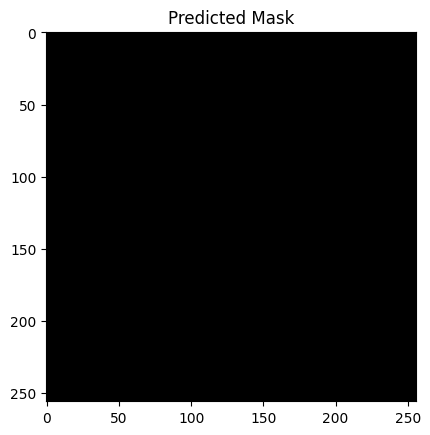

In [ ]:
import matplotlib.pyplot as plt


predicted_mask = predicted_mask.squeeze()

#display the predicted mask
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.show()